In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_decision_regions
plt.style.use('ggplot')


In [13]:
df = pd.read_csv('genre.csv')

# прбираємо перші два стовпці 
df = df.iloc[:, 2:]

# вибираємо лише ті строки, 
# в яких мітки класів рівняються 5 і 10 
# що відповідають жанрам HipHop і Rock відповідно
df = df.query('Class == 5 | Class == 10').reset_index(drop=True)


In [14]:
df

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.00401,0.1010,0.5690,116.454,251733.0,4,10
2,66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
3,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.01610,0.1720,0.0918,199.060,229960.0,4,10
4,59.0,0.387,0.922,9.0,-5.192,0,0.0674,0.004870,NaN,0.1870,0.4170,146.478,222947.0,4,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6391,69.0,0.552,0.846,9.0,-4.912,1,0.3420,0.011400,NaN,0.3090,0.5540,98.560,236600.0,1,5
6392,44.0,0.524,0.613,1.0,-10.025,1,0.0256,0.013500,0.65300,0.0860,0.4430,102.399,362960.0,4,10
6393,55.0,0.384,0.820,5.0,-3.928,0,0.2010,0.397000,NaN,0.1140,0.4410,90.712,178605.0,4,5
6394,59.0,0.262,0.820,7.0,-11.621,1,0.0428,0.010300,0.09140,0.1010,0.2540,155.197,246333.0,4,10


In [15]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

Popularity - 2%
danceability - 0%
energy - 0%
key - 11%
loudness - 0%
mode - 0%
speechiness - 0%
acousticness - 0%
instrumentalness - 30%
liveness - 0%
valence - 0%
tempo - 0%
duration_in min/ms - 0%
time_signature - 0%
Class - 0%


In [16]:
df['Popularity'] = df['Popularity'].fillna(df['Popularity'].median())
df['key'] = df['key'].fillna(df['key'].median())
df['instrumentalness'] = df['instrumentalness'].fillna(df['instrumentalness'].median())

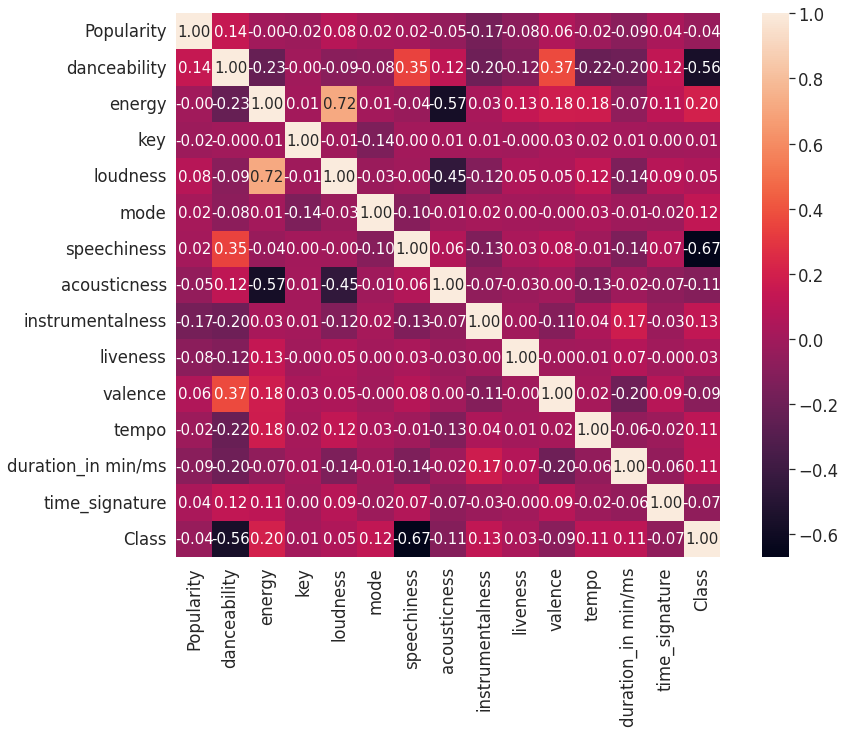

In [17]:
cols = df.columns
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
plt.figure(figsize=(15, 10))
hm = sns.heatmap(cm, annot=True, square=True, fmt='.2f', yticklabels=cols, xticklabels=cols, 
                 annot_kws={'size':15} )

In [18]:
# вибираємо фічі з найбільшою кореляцією
df = df[['danceability', 'speechiness', 'Class']]

In [19]:
# змінюємо мітки класів
# HipHop: 0
# Rock: 1
df.loc[df['Class'] == 5, 'Class'] = 0
df.loc[df['Class'] == 10, 'Class'] = 1

/home/laslo/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


## level the dataframe

In [20]:
# оскільки міток класа 1 майже у 3,5 раза більше ніж міток 0
# потрібно урівняти кількість міток обох класів
# оскільки класифікатор уже покаже непогані результати просто на будь-який запит відповідаючи 1
df = new_df = pd.concat([df[df['Class'] == 0], df[df['Class'] == 1][:1500]]).reset_index(drop=True)

In [21]:
df[df['Class'] == 1].count() / df[df['Class'] == 0].count()

danceability    1.036628
speechiness     1.036628
Class           1.036628
dtype: float64

## Split

In [22]:
df = df.sample(frac=1).reset_index(drop=True)
x_train, x_test, y_train, y_test = train_test_split(df.drop(['Class'], axis = 1), df['Class'], test_size=0.33)

## Standardize the Variables

In [23]:
scaler = StandardScaler()
scaler.fit(x_train)

scaled_x_train = scaler.transform(x_train) 
scaled_x_test = scaler.transform(x_test)

# kNN

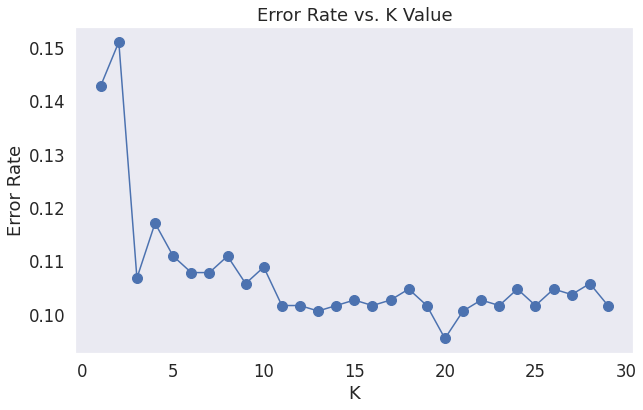

In [24]:
error_rate = []

for i in range(1,30):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(scaled_x_train,y_train)
    pred_i = knn.predict(scaled_x_test)
    error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,30), error_rate, marker='o', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.grid()

In [25]:
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(scaled_x_train, y_train)
pred = knn.predict(scaled_x_test)
print(accuracy_score(y_test,pred))

0.8982528263103803


<AxesSubplot:>

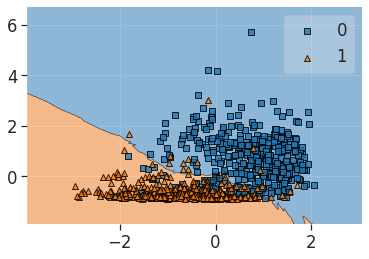

In [26]:

plot_decision_regions(scaled_x_test, y_test.values, clf=knn)

# Decision tree

In [27]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

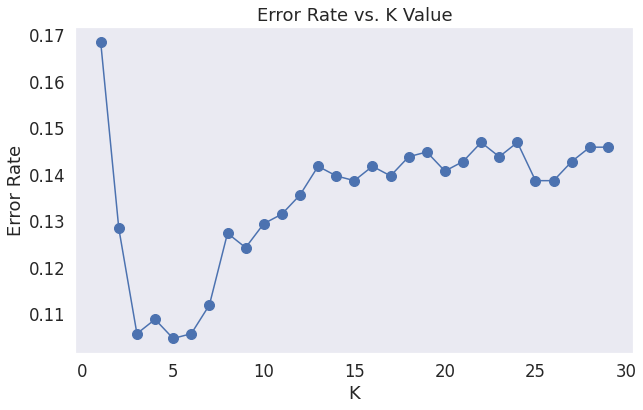

In [28]:
error_rate = []

for i in range(1,30):
    tree = DecisionTreeClassifier(max_depth=i)
    tree.fit(x_train,y_train)
    pred_i = tree.predict(x_test)
    error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,30), error_rate, marker='o', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.grid()

In [29]:
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(x_train, y_train)
pred = tree.predict(x_test)
print(accuracy_score(y_test,pred))

0.894141829393628


<AxesSubplot:>

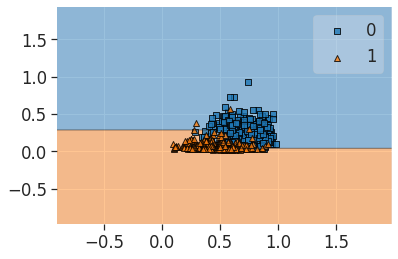

In [30]:
plot_decision_regions(x_test.values, y_test.values, clf=tree)

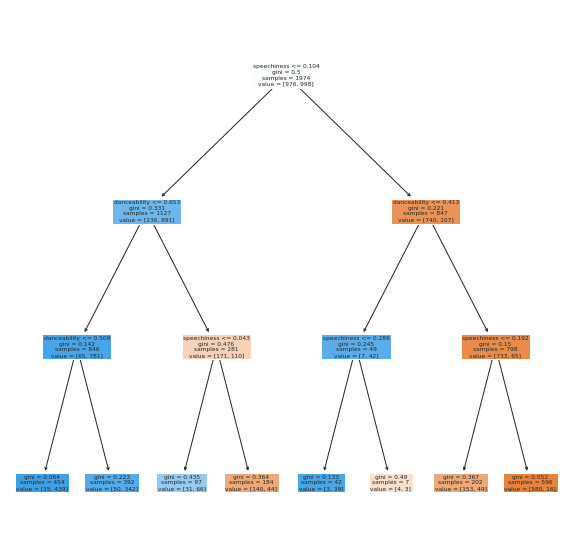

In [31]:
plt.figure(figsize = (10, 10))
plot_tree(tree, feature_names = ['danceability', 'speechiness'], filled = True)
plt.show()

# SVM

In [32]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [37]:
n = 5
param_grid = {'C': [.1 * 10 ** i for i in range(0, n + 1)], 'gamma': [1 * 0.1 ** i for i in range(0, n + 1)], 'kernel': ['rbf']}

In [38]:
svm_grid = GridSearchCV(SVC(), param_grid, refit=True)
svm_grid.fit(scaled_x_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0],
                         'gamma': [1.0, 0.1, 0.010000000000000002,
                                   0.0010000000000000002,
                                   0.00010000000000000002,
                                   1.0000000000000003e-05],
                         'kernel': ['rbf']})

In [40]:
svm_grid.best_params_

{'C': 10000.0, 'gamma': 0.1, 'kernel': 'rbf'}

In [42]:
pred = svm_grid.predict(scaled_x_test)
print(accuracy_score(y_test,pred))

0.8961973278520041


<AxesSubplot:>

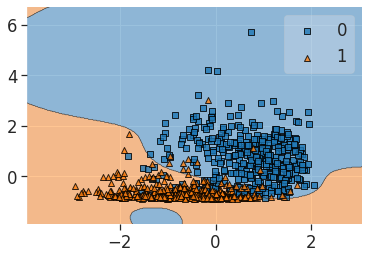

In [45]:
plot_decision_regions(scaled_x_test, y_test.values, clf=svm_grid)

# Random Forest

In [47]:
from sklearn.ensemble import RandomForestClassifier

In [48]:
n = 10
param_grid = {'n_estimators': [10 * i for i in range(1, n + 1)], 'criterion': ['gini','entropy'], 'max_depth': range(1, n + 1)}

In [50]:
forest_grid = GridSearchCV(RandomForestClassifier(), param_grid, refit=True)
forest_grid.fit(x_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 11),
                         'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100]})

In [52]:
forest_grid.best_params_

{'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 60}

In [53]:
pred = forest_grid.predict(x_test)
print(accuracy_score(y_test,pred))

0.9013360739979445


<AxesSubplot:>

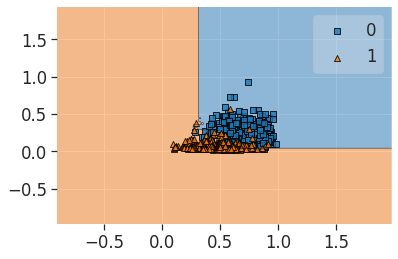

In [54]:
plot_decision_regions(x_test.values, y_test.values, clf=forest_grid)

# AdaBoost

In [55]:
from sklearn.ensemble import AdaBoostClassifier

In [60]:
n = 10
param_grid = {'n_estimators': [10 * i for i in range(1, n + 1)]}

In [61]:
ab_grid = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(max_depth=1)), param_grid, refit=True)
ab_grid.fit(scaled_x_train, y_train)

GridSearchCV(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1)),
             param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100]})

In [62]:
ab_grid.best_params_

{'n_estimators': 80}

In [63]:
pred = ab_grid.predict(scaled_x_test)
print(accuracy_score(y_test,pred))

0.8910585817060637


<AxesSubplot:>

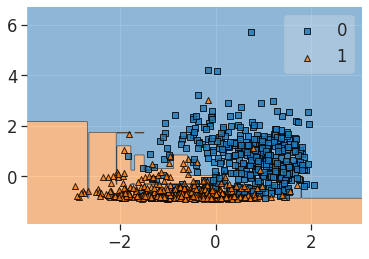

In [64]:
plot_decision_regions(scaled_x_test, y_test.values, clf=ab_grid)